## Part 4.1. Hybrid recommender with LightFM library

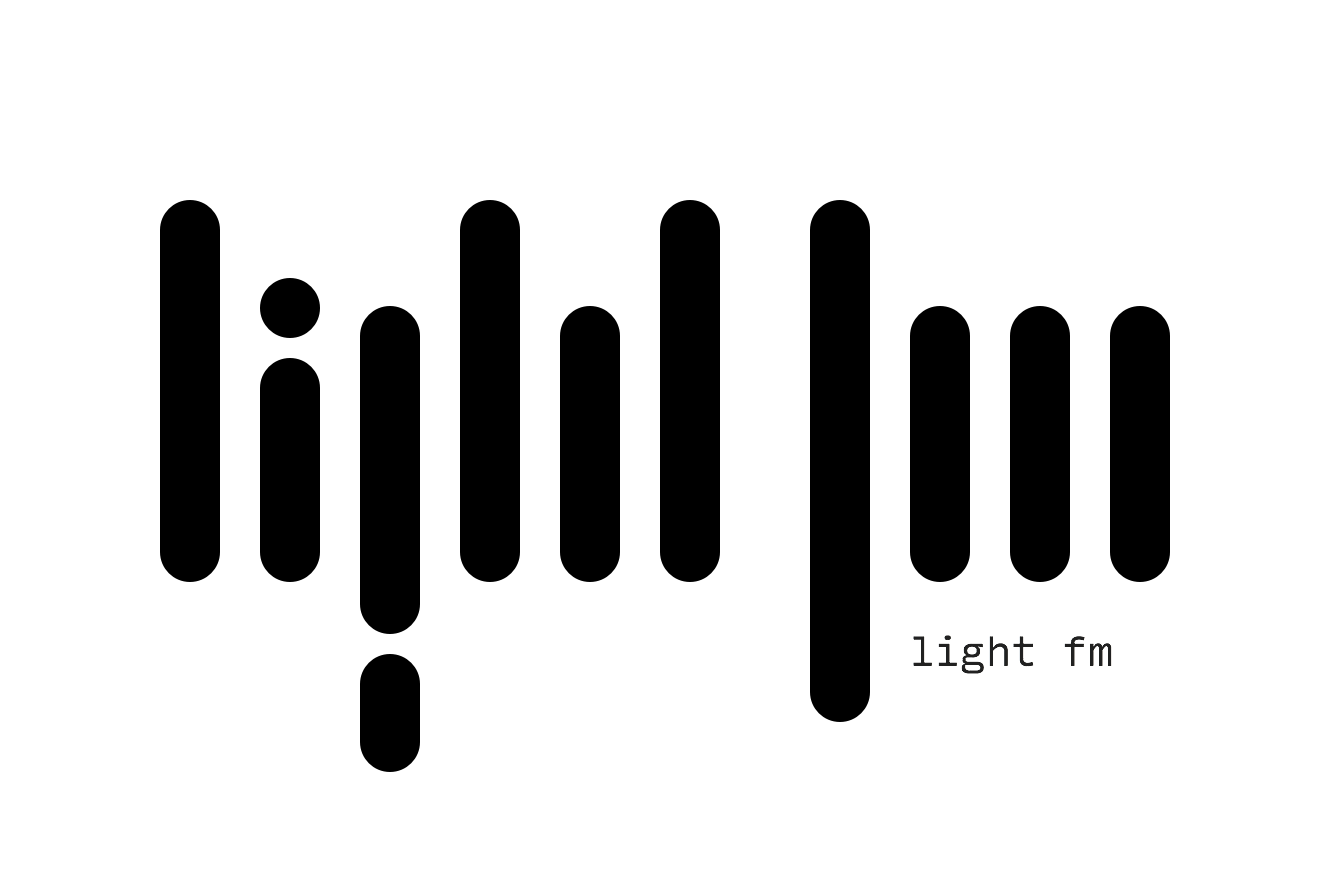

## The plan

- ### Data loading
- ### Useful classes and methods
- ### Solution without features
- ### Solution only on features
- ### Hybrid solution
- ### Hyperparameters search
- ### Final model evaluation
- ### Model saving

In [1]:
import numpy as np
import pandas as pd
import lightfm

import optuna

import warnings
import pickle

from recsys.dataset.column_categorizer import ColumnCategorizer
from recsys.models.lightfm import lfm_train_preprocessing, lfm_model_evaluation, get_mean_roc_auc
from recsys.config import opt

/opt/homebrew/Caskroom/miniforge/base/envs/recsys-experiments/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/recsys-experiments/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading

In [2]:
data_train_pos = pd.read_parquet(opt.path_to_data / "prepared-train-pos.parquet")
data_train_all = pd.read_parquet(opt.path_to_data / "prepared-train-all.parquet")
data_val = pd.read_parquet(opt.path_to_data / "prepared-validation.parquet")
data_test = pd.read_parquet(opt.path_to_data / "prepared-test.parquet")
cold_users_data = pd.read_parquet(opt.path_to_data / "cold-users-data.parquet")
cold_items_data = pd.read_parquet(opt.path_to_data / "cold-items-data.parquet")

In [3]:
data_train_pos.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
1,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
2,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
3,73q3/E5FIUwCSo9uPyhKcc1FNO9DqnaZqX7uDK5Rr7E=,XywiBSwrlFPkeg1pNJcH99AxP8loYVD8Twr+WrjjqxM=,discover,Online playlist more,online-playlist,1,199392.0,139|125|109,Al Green,Al Green,NaN,52.0,Let's Stay Together,US2HK0913701,1,0,NaN,7,2016-01-05,2017-10-05
4,M6fFPRO/pOaaWoergvHHsFzEUbW4YU6DKxqBDyYSbYU=,yiaUAbtf5E8J/aLzeDe3V/zT/sXzbZiIE3m/JvEB1jI=,search,Search,song,1,235416.0,444,Girls' Generation (少女時代),Cho Yun Kyoung| Kim Hee Jung| Harvey Mason Jr....,NaN,31.0,Mr.Mr.,KRA301300351,1,0,NaN,4,2016-12-13,2016-12-16


In [4]:
data_train_all.shape, data_train_pos.shape, data_val.shape, data_test.shape, cold_users_data.shape, cold_items_data.shape

((5046332, 20),
 (2539875, 20),
 (630792, 20),
 (630792, 20),
 (715482, 20),
 (392174, 20))

### Useful classes and methods

First of all, I recommend you to look at some links on this topic:
- https://making.lyst.com/lightfm/docs/home.html
- http://building-babylon.net/2016/01/26/metadata-embeddings-for-user-and-item-cold-start-recommendations/
- https://arxiv.org/pdf/1507.08439.pdf

So, the typical graph for the final score calculation:

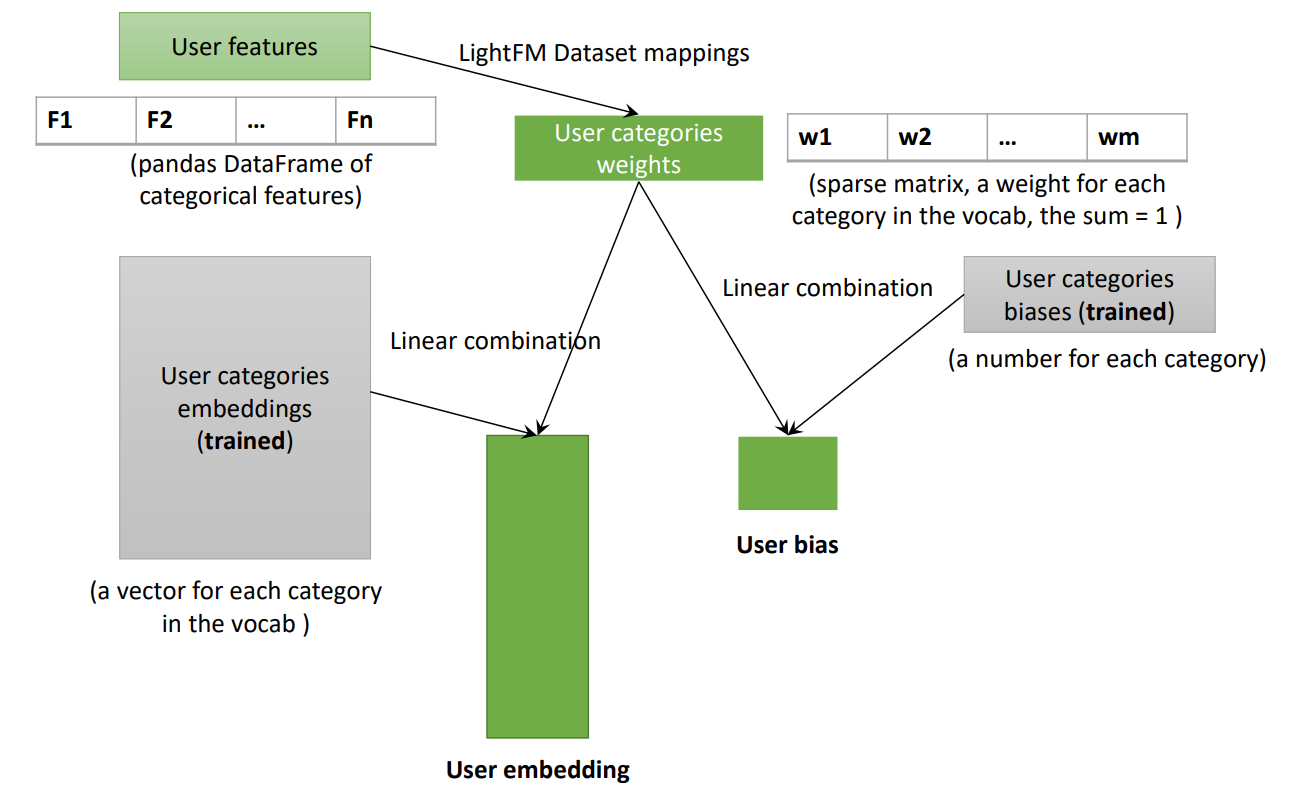

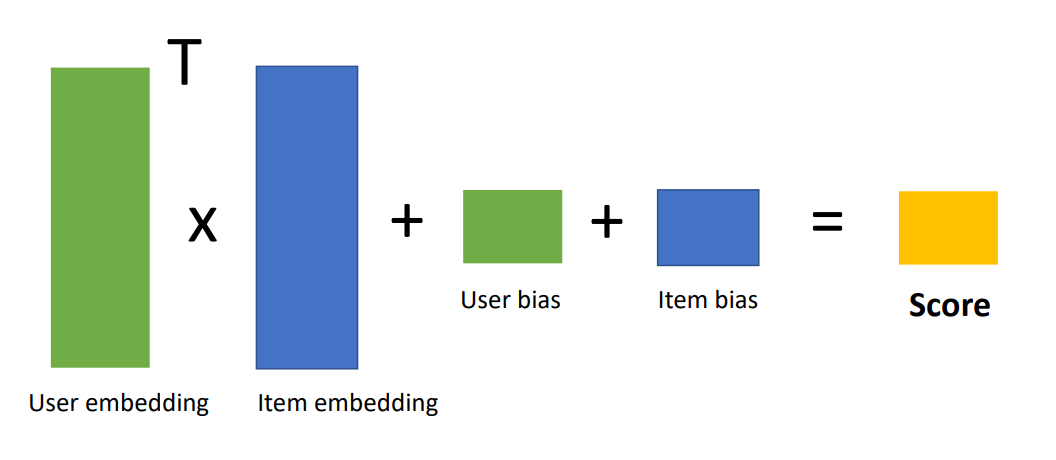

Although this graph describes the inference time, it is very similar to the training graph

In [5]:
#######
NUM_THREADS = 1 #Number of cores
#######

### Without additional features, only responces in train

In [6]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = []
user_id_column = opt.dataset.user_id_col
item_id_column = opt.dataset.item_id_col
target_column = opt.dataset.target_col
score_column = opt.dataset.score_col

#Other lists of features
cat_cols_to_change = [] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, target_column]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Categorizer for numeric features (here - only patch for interfaces)
categorizer = ColumnCategorizer(
    qs=QS, new_columns=numeric_cols, old_columns=numeric_cols
)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [7]:
%%time
prep_dict = lfm_train_preprocessing(
    data_train_pos,
    categorizer=categorizer,
    cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    user_identity_features=True,
    item_identity_features=True
)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 8.56 s, sys: 335 ms, total: 8.89 s
Wall time: 9.02 s


In [8]:
%%time
#####
EPOCH_NUM = 10

model_params = {
    "loss": "warp",
    "random_state": opt.seed,
    "no_components": 100
}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(
        interactions=interactions,
        user_features=user_features,
        item_features=item_features,
        num_threads=NUM_THREADS,
    )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 1min 36s, sys: 364 ms, total: 1min 36s
Wall time: 1min 36s


### Let's evaluate our model on different test sets

----------
Validation data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6617485407947222
Users mean reciprocal rank on test: 0.9249010880316518
Users mean precision@5 on test: 0.8246290801186943


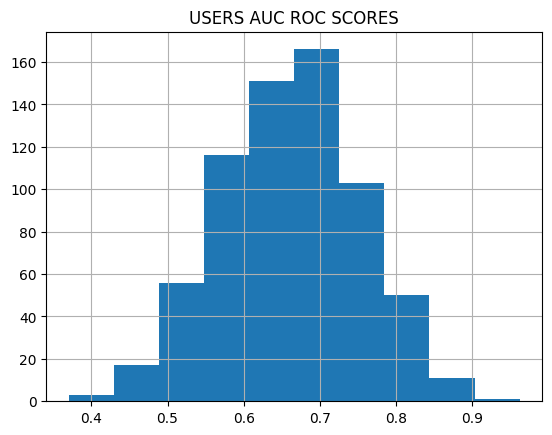

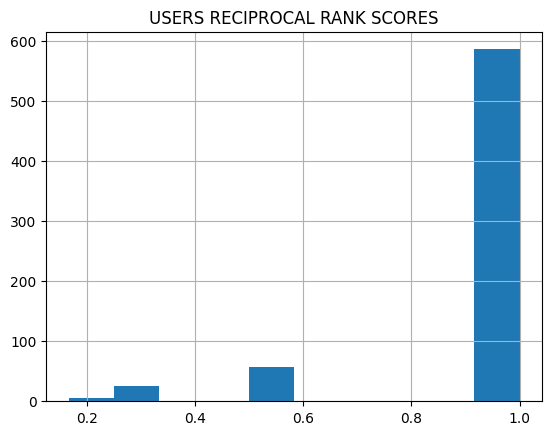

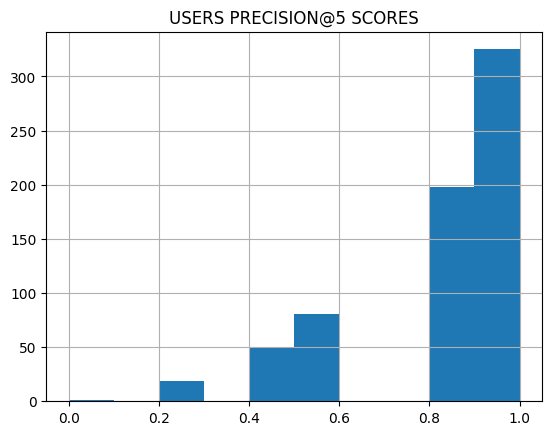

In [9]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(
    model, data_val,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

Check out our scores

In [10]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,-3.621364
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,-2.440200
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,-4.491340
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,0.236501
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,1.842033


----------
Test data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6653819667062661
Users mean reciprocal rank on test: 0.9210740740740742
Users mean precision@5 on test: 0.8254814814814814


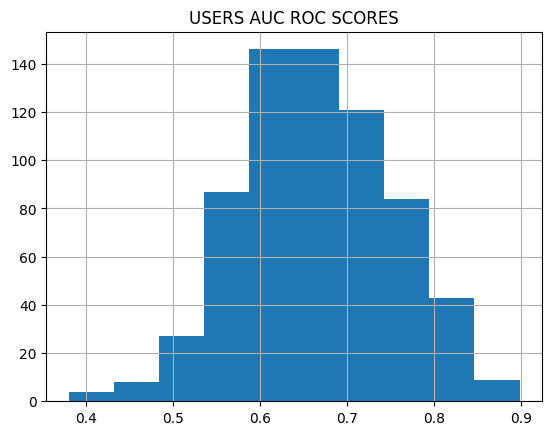

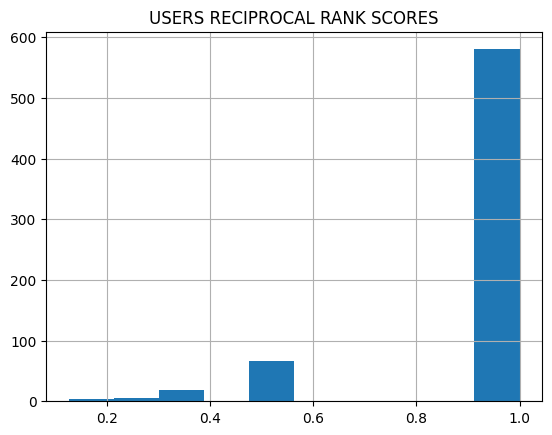

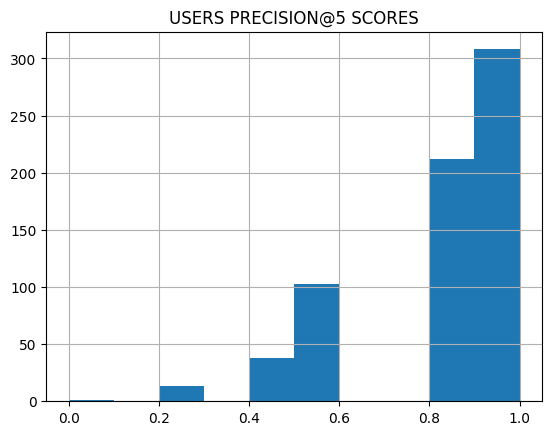

In [11]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(
    model, data_test,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold users data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.5921181596688592
Users mean reciprocal rank on test: 0.8653606373420025
Users mean precision@5 on test: 0.7467175572519085


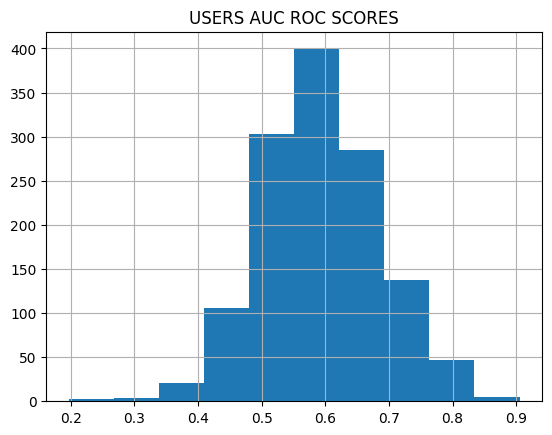

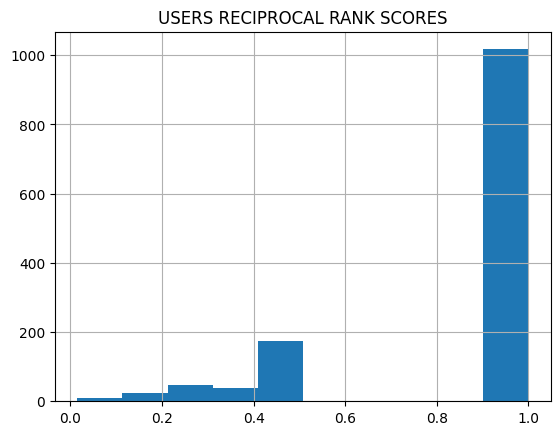

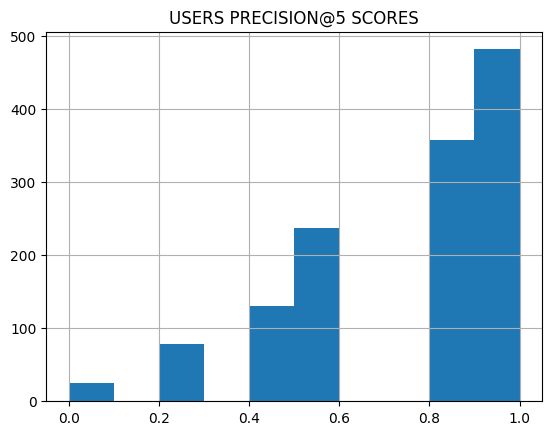

In [12]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_users_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold items data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.5
Users mean reciprocal rank on test: 0.672866971838803
Users mean precision@5 on test: 0.48732394366197185


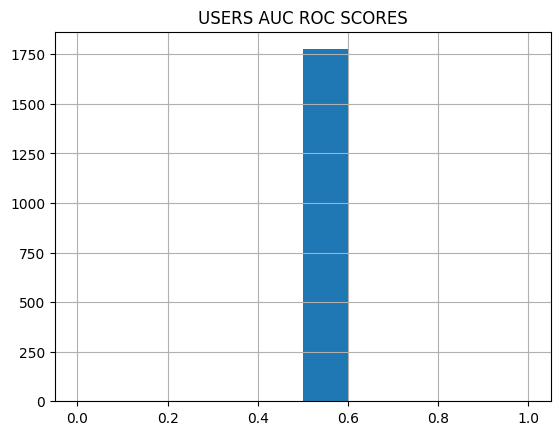

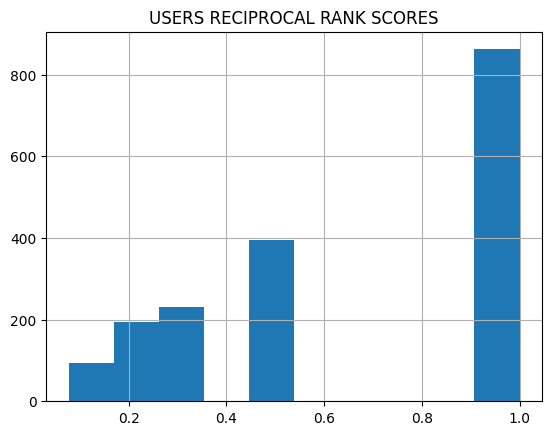

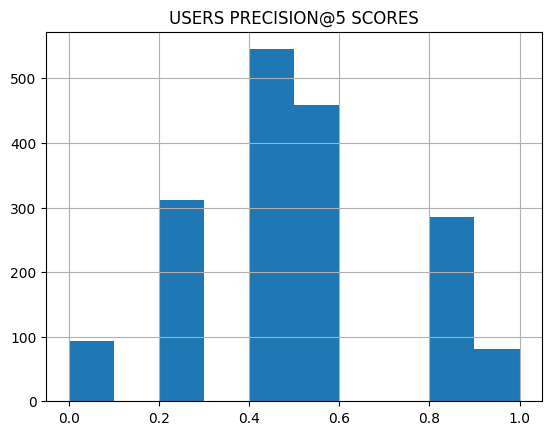

In [13]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_items_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

### You can see that in the last case with cold items the model works as a random algorithm. Can we do better?

### Let's try to build a model only on features, without any responces data

In [14]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = ["city", "gender", "bd", "registered_via"]
item_fe_cols = ["song_length", "genre_ids", "artist_name", "composer", "language", "source_type"]
user_id_column = opt.dataset.user_id_col
item_id_column = opt.dataset.item_id_col
target_column = opt.dataset.target_col
score_column = opt.dataset.score_col

#Other lists of features
cat_cols_to_change = ["genre_ids", "language", "city", "registered_via"] #columns to add name to value
numeric_cols = ["bd", "song_length"] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, target_column]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Numeric features categorizer
categorizer = ColumnCategorizer(
    qs=QS, new_columns=numeric_cols, old_columns=numeric_cols
)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=['bd', 'song_length'],
                  old_columns=['bd', 'song_length'],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [15]:
%%time
prep_dict = lfm_train_preprocessing(
    data_train_pos,
    categorizer=categorizer,
    cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    user_identity_features=False, #look at this parameter
    item_identity_features=False, #look at this parameter
)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 22.6 s, sys: 546 ms, total: 23.2 s
Wall time: 23.3 s


In [16]:
%%time
#####
EPOCH_NUM = 10
model_params = {
    "loss": "warp",
    "random_state": opt.seed,
    "no_components": 100
}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(
        interactions=interactions,
        user_features=user_features,
        item_features=item_features,
        num_threads=NUM_THREADS,
    )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 3min 20s, sys: 671 ms, total: 3min 21s
Wall time: 3min 21s


----------
Validation data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6084743967476244
Users mean reciprocal rank on test: 0.8540401364214419
Users mean precision@5 on test: 0.715727002967359


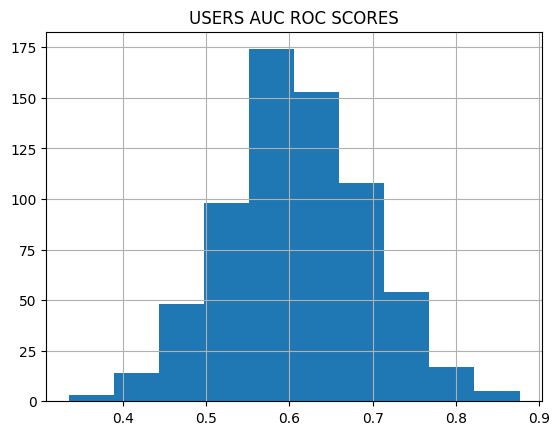

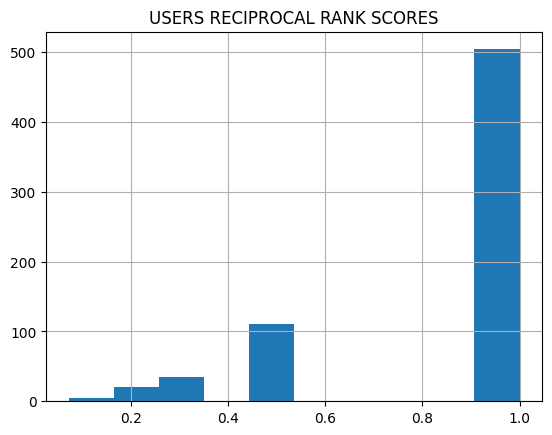

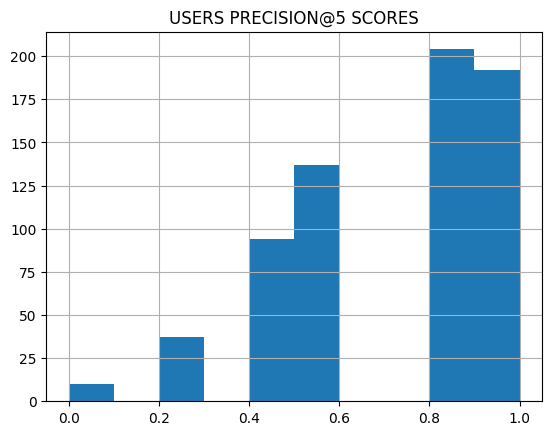

In [17]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(
    model, data_val,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold items data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.5702302038250457
Users mean reciprocal rank on test: 0.7199649208381602
Users mean precision@5 on test: 0.5494084507042254


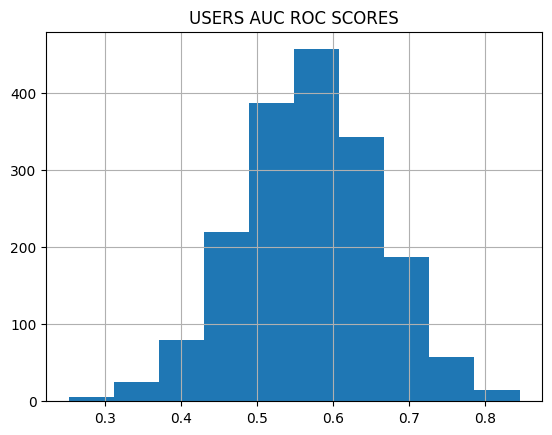

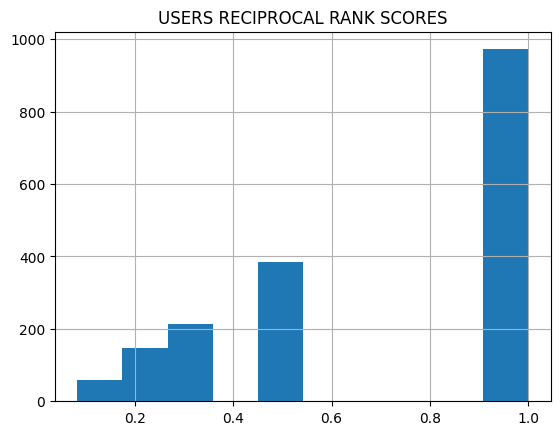

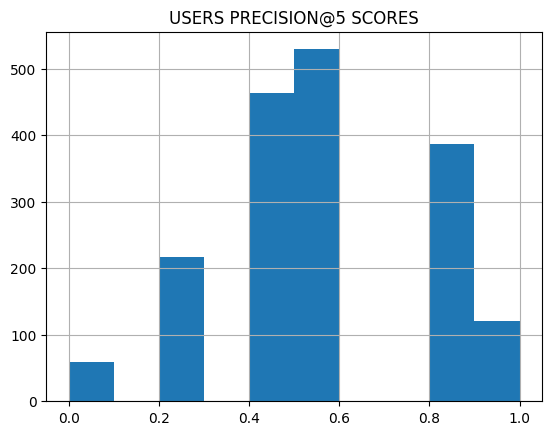

In [18]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_items_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

### So, we have the result for the last case, but quality on the other sets is worse... Let's try to use only responces for users and only features for items.

In [19]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = opt.dataset.user_id_col
item_id_column = opt.dataset.item_id_col
target_column = opt.dataset.target_col
score_column = opt.dataset.score_col

#Other lists of features
cat_cols_to_change = ["genre_ids", "language"] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, target_column]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Categorizer for numeric features (here, it's only a patch for our interfaces)
categorizer = ColumnCategorizer(
    qs=QS, new_columns=numeric_cols, old_columns=numeric_cols
)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [20]:
%%time
prep_dict = lfm_train_preprocessing(
    data_train_pos,
    categorizer=categorizer,
    cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    user_identity_features=True,
    item_identity_features=False,
)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 14.3 s, sys: 358 ms, total: 14.6 s
Wall time: 14.7 s


In [21]:
%%time
#####
EPOCH_NUM = 10
model_params = {
    "loss": "warp",
    "random_state": opt.seed,
    "no_components": 100
}
#####

model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(
        interactions=interactions,
        user_features=user_features,
        item_features=item_features,
        num_threads=NUM_THREADS,
    )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
CPU times: user 2min 11s, sys: 412 ms, total: 2min 12s
Wall time: 2min 12s


----------
Validation data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6571638048188292
Users mean reciprocal rank on test: 0.8856083086053412
Users mean precision@5 on test: 0.7608308605341245


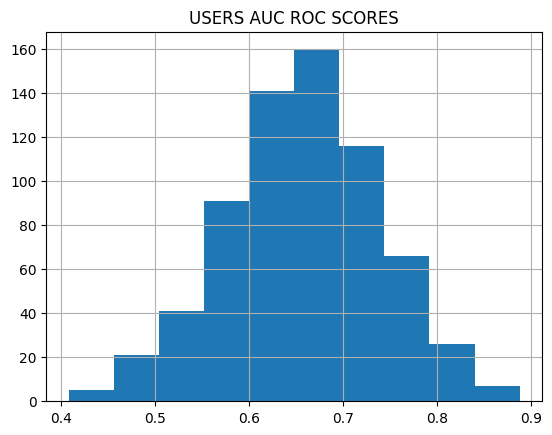

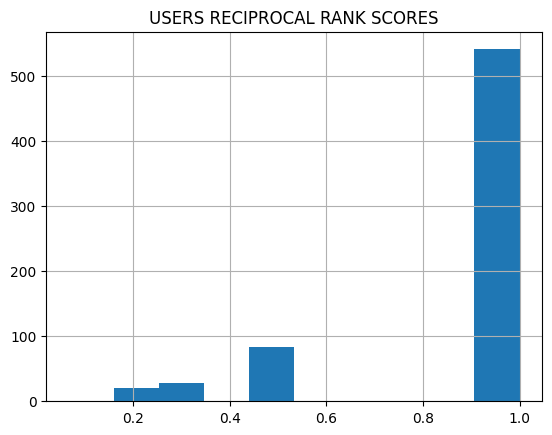

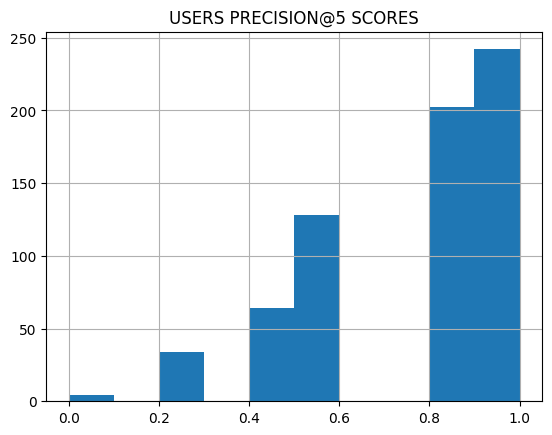

In [22]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(
    model, data_val,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Test data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6602759460899509
Users mean reciprocal rank on test: 0.8994462081128748
Users mean precision@5 on test: 0.7804444444444444


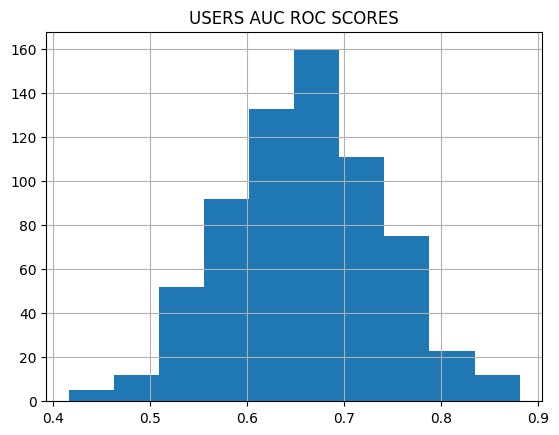

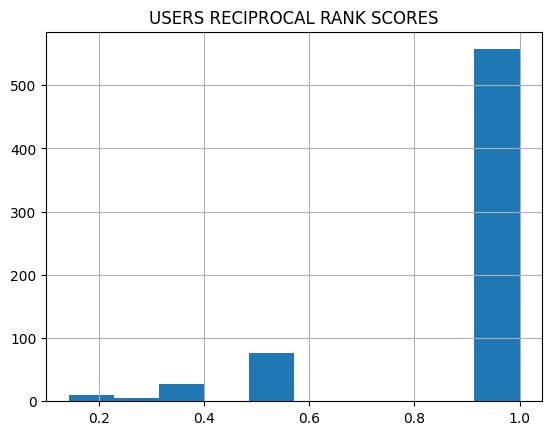

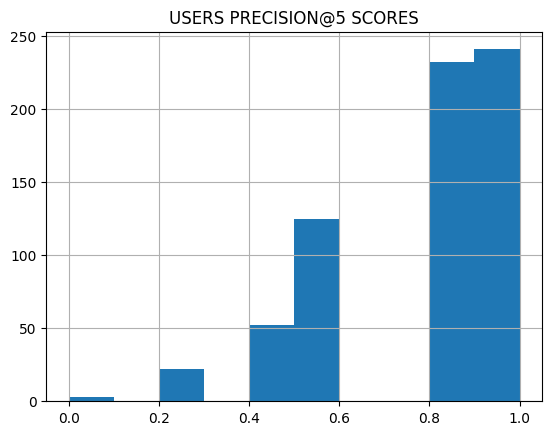

In [23]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(
    model, data_test,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold users data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.5786372047028745
Users mean reciprocal rank on test: 0.788976009950561
Users mean precision@5 on test: 0.6325190839694655


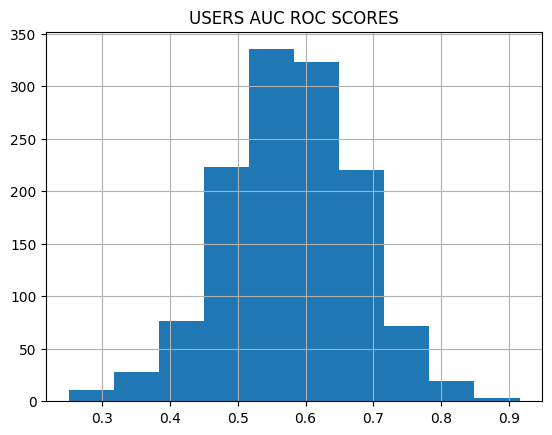

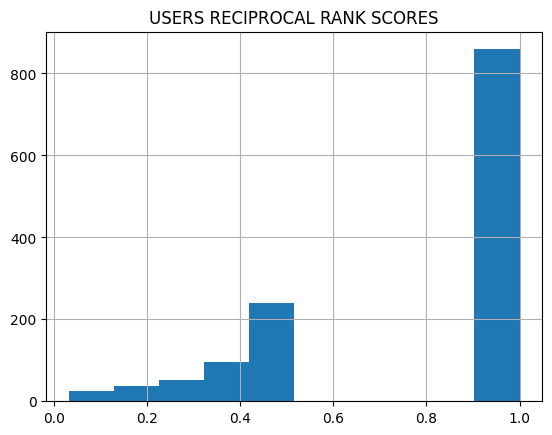

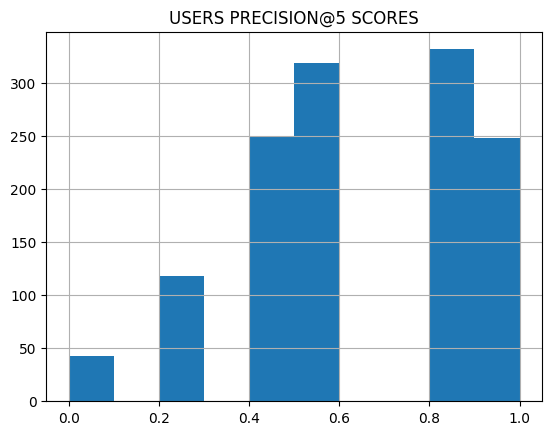

In [24]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_users_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold items data
----------


/Users/romankryvokhyzha/PycharmProjects/recsys-experiments/recsys/metrics/__init__.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user_id, data_us in data_new.groupby([user_id_col]):


Users mean AUC ROC on test: 0.6254345760412826
Users mean reciprocal rank on test: 0.8002014308070646
Users mean precision@5 on test: 0.6623098591549296


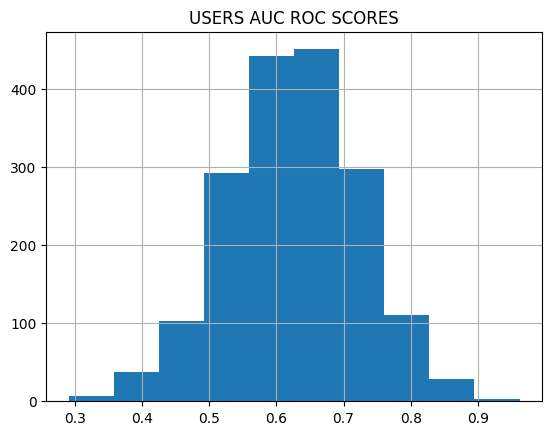

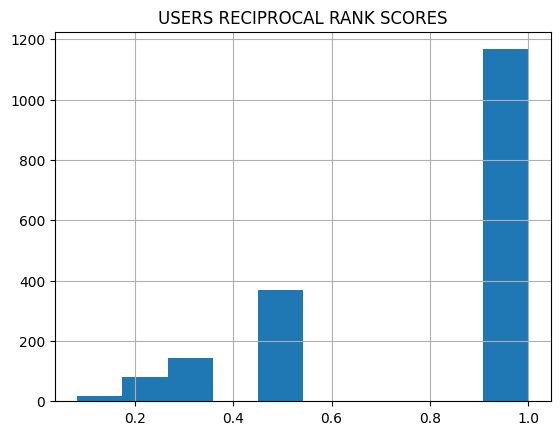

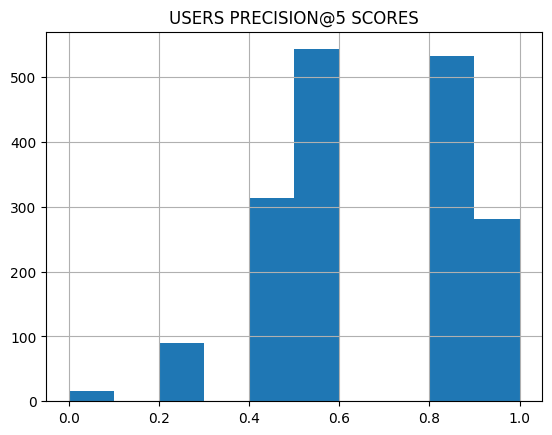

In [25]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_items_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

### Better results!

### So, here we'll tune the hyperparameters via optuna and find the best algorithm (only a starter, you can try more combinations).

In [26]:
warnings.filterwarnings('ignore')

######
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)

K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75

EPOCH_NUM = 2
NUM_THREADS = 4

user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = opt.dataset.user_id_col
item_id_column = opt.dataset.item_id_col
target_column = opt.dataset.target_col
score_column = opt.dataset.score_col

cat_cols_to_change = ["genre_ids", "language", "city", "registered_via"] #columns to add a name to a value
numeric_cols = ["bd"] #this columns will be categorized

#Columns in the result dataframe with targets
result_cols = [user_id_column, item_id_column, target_column]

categorizer = ColumnCategorizer(
    qs=QS, new_columns=numeric_cols, old_columns=numeric_cols
)
categorizer.fit(data_train_all)

N_TRIALS = 20
######

def objective(trial):
    ##
    include_user_features = trial.suggest_categorical(
        "include_user_features", ["Yes", "No"]
    )
    user_fe_cols = []
    if include_user_features == "Yes":
        user_fe_cols = ["city", "gender", "bd", "registered_via"]
    ##
    prep_dict = lfm_train_preprocessing(
        data_train_pos,
        categorizer=categorizer,
        cat_cols_to_change=cat_cols_to_change,
        user_fe_cols=user_fe_cols,
        item_fe_cols=item_fe_cols,
        user_id_column=user_id_column,
        item_id_column=item_id_column,
        user_identity_features=True,
        item_identity_features=False,
    )
    dataset = prep_dict["dataset"]
    interactions = prep_dict["interactions"]
    user_features = prep_dict["user_features"]
    item_features = prep_dict["item_features"]
    
    params = {
        "no_components": trial.suggest_int("no_components", 10, 200),
        "loss": trial.suggest_categorical("loss", ["warp", "bpr"])
    }
    params["random_state"] = opt.seed

    model = lightfm.LightFM(**params)
    for epoch in range(0, EPOCH_NUM):
        model.fit_partial(
            interactions=interactions,
            user_features=user_features,
            item_features=item_features,
            num_threads=NUM_THREADS,
        )
    
    mean_roc_auc_score = get_mean_roc_auc(
        model, data_val,
        result_cols=result_cols,
        lfm_dataset=dataset,
        categorizer=categorizer,
        n=K, cat_cols_to_change=cat_cols_to_change,
        user_fe_cols=user_fe_cols,
        item_fe_cols=item_fe_cols,
        user_id_column=user_id_column,
        item_id_column=item_id_column,
        score_col=score_column,
        target_col=target_column,
        train_user_weights=user_features,
        train_item_weights=item_features,
        min_prop=MIN_PROP, max_prop=MAX_PROP
    )
    return mean_roc_auc_score

study = optuna.create_study(direction="maximize", study_name="my_lfm_optimization")
study.optimize(objective, n_trials=N_TRIALS)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-02-08 00:57:26,895] A new study created in memory with name: my_lfm_optimization
[I 2023-02-08 00:58:06,221] Trial 0 finished with value: 0.6367986019155372 and parameters: {'include_user_features': 'No', 'no_components': 60, 'loss': 'warp'}. Best is trial 0 with value: 0.6367986019155372.
[I 2023-02-08 00:59:16,775] Trial 1 finished with value: 0.5491967995538338 and parameters: {'include_user_features': 'Yes', 'no_components': 123, 'loss': 'bpr'}. Best is trial 0 with value: 0.6367986019155372.
[I 2023-02-08 01:00:02,886] Trial 2 finished with value: 0.5516550356463763 and parameters: {'include_user_features': 'Yes', 'no_components': 50, 'loss': 'bpr'}. Best is trial 0 with value: 0.6367986019155372.
[I 2023-02-08 01:00:41,610] Trial 3 finished with value: 0.5735901559735209 and parameters: {'include_user_features': 'No', 'no_components': 48, 'loss': 'bpr'}. Best is trial 0 with value: 0.6367986019155372.
[I 2023-02-08 01:01:48,953] Trial 4 finished with value: 0.601809025861

Number of finished trials: 20
Best trial:
  Value: 0.6456742418835655
  Params: 
    include_user_features: No
    no_components: 198
    loss: warp


In [27]:
trial.params

{'include_user_features': 'No', 'no_components': 198, 'loss': 'warp'}

In [28]:
#####
EPOCH_NUM = 30
#####


user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]


prep_dict = lfm_train_preprocessing(
    data_train_pos,
    categorizer=categorizer,
    cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    user_identity_features=True,
    item_identity_features=False,
)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]


model_params = {
    'loss': trial.params["loss"],
    'no_components': trial.params["no_components"],
}
model_params["random_state"] = opt.seed
model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    model.fit_partial(
        interactions=interactions,
        user_features=user_features,
        item_features=item_features,
        num_threads=NUM_THREADS,
    )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


----------
Validation data
----------
Users mean AUC ROC on test: 0.6764844633950342
Users mean reciprocal rank on test: 0.8952663558004803
Users mean precision@5 on test: 0.7816023738872403


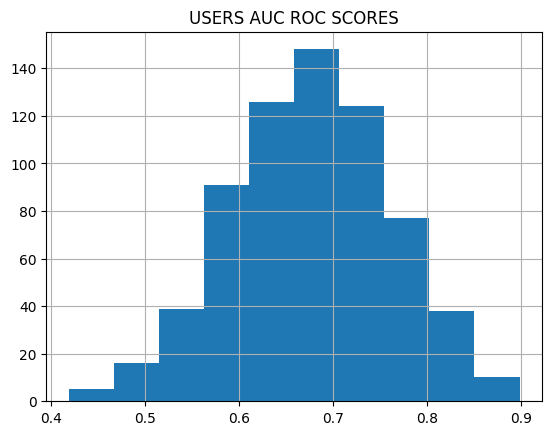

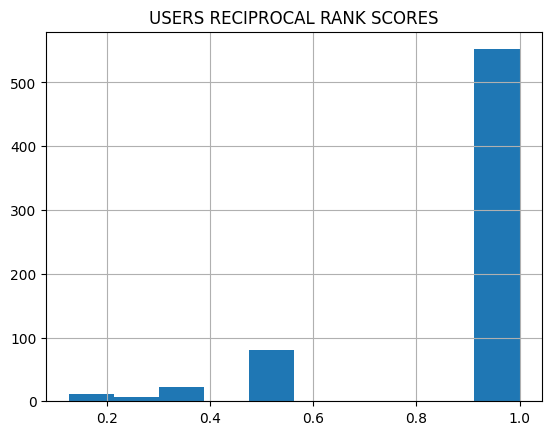

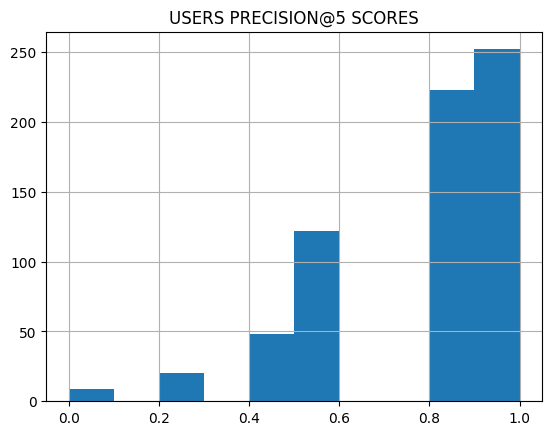

In [29]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Validation data")
print("----------")
val_real_pred = lfm_model_evaluation(
    model, data_val,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

In [30]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,-5.044110
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,-5.346222
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,-6.800172
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,-0.719936
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,-2.304782


----------
Test data
----------
Users mean AUC ROC on test: 0.678366051147269
Users mean reciprocal rank on test: 0.9018888888888889
Users mean precision@5 on test: 0.7893333333333332


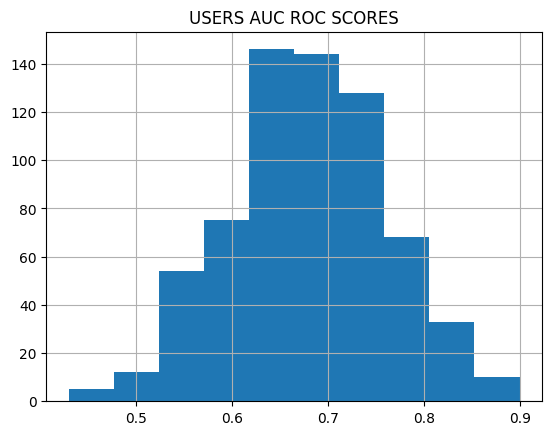

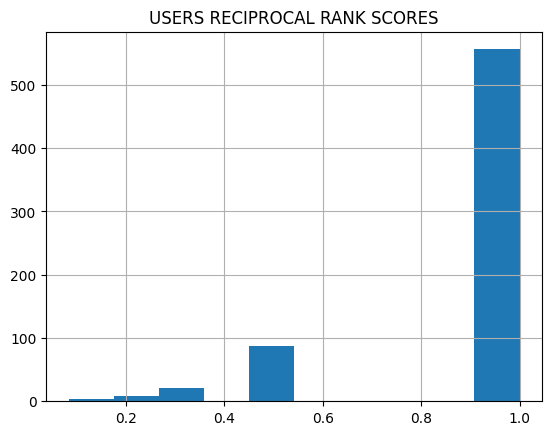

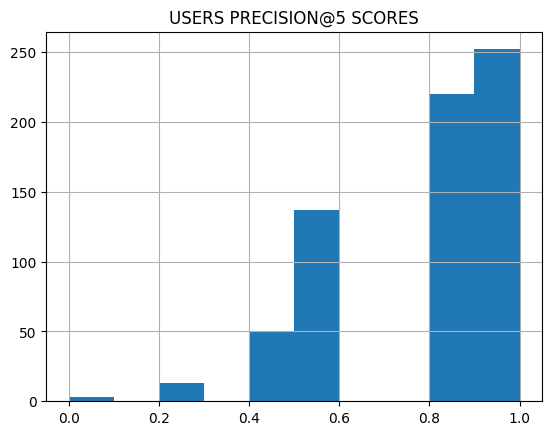

In [31]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Test data")
print("----------")
_ = lfm_model_evaluation(
    model, data_test,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold users data
----------
Users mean AUC ROC on test: 0.5768856758508222
Users mean reciprocal rank on test: 0.7825554036160705
Users mean precision@5 on test: 0.628091603053435


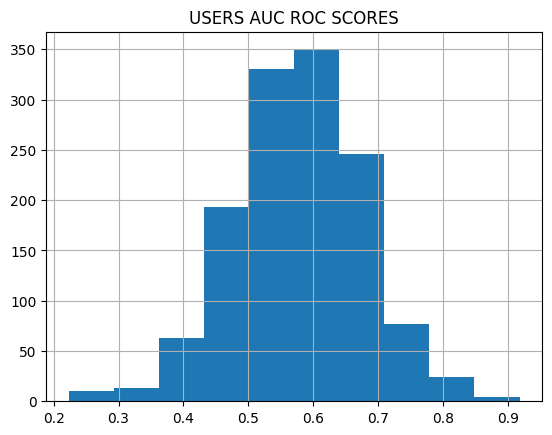

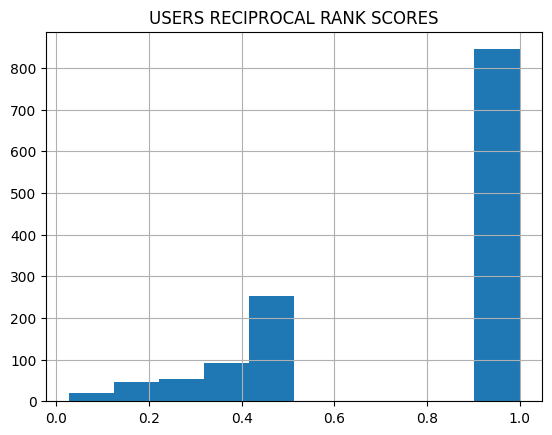

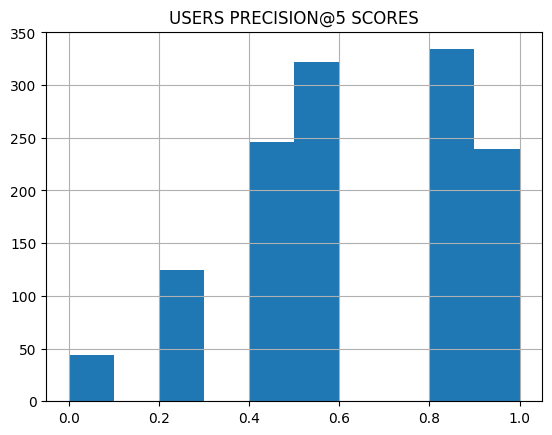

In [32]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold users data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_users_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.6349445831016594
Users mean reciprocal rank on test: 0.805909009613235
Users mean precision@5 on test: 0.6731267605633803


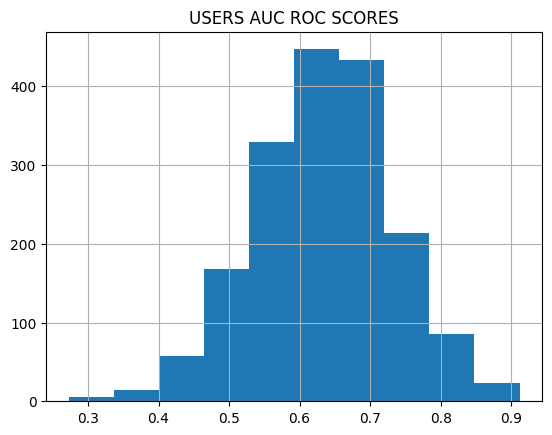

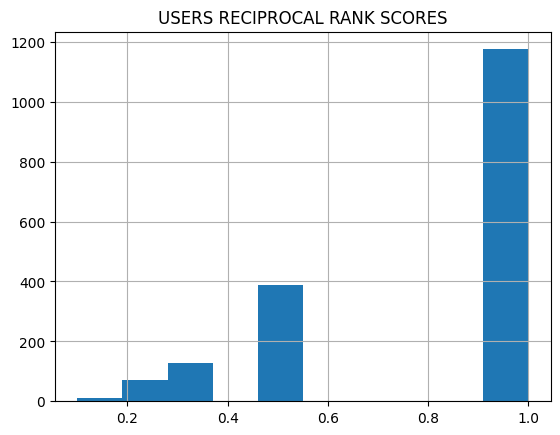

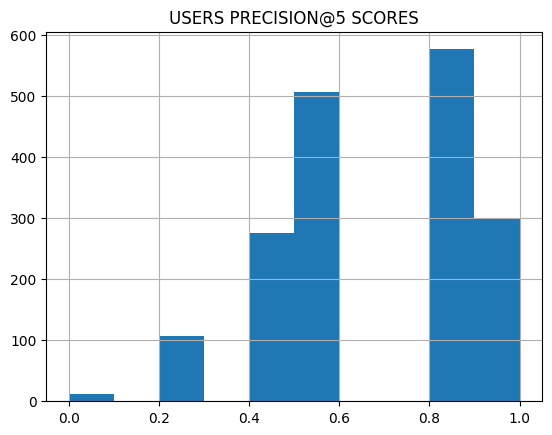

In [33]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Cold items data")
print("----------")
_ = lfm_model_evaluation(
    model, cold_items_data,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

----------
Train data
----------
Users mean AUC ROC on test: 0.7392906884768314
Users mean reciprocal rank on test: 0.9112569090929401
Users mean precision@5 on test: 0.8337790288529207


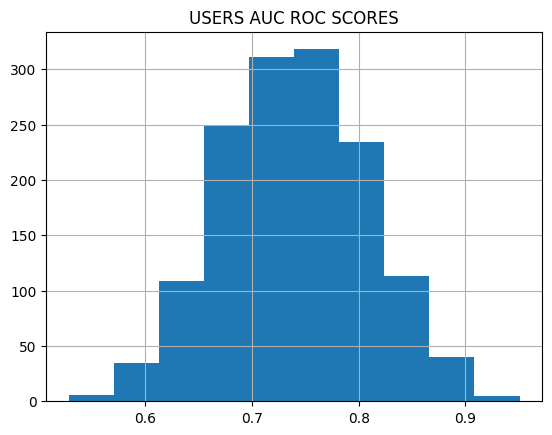

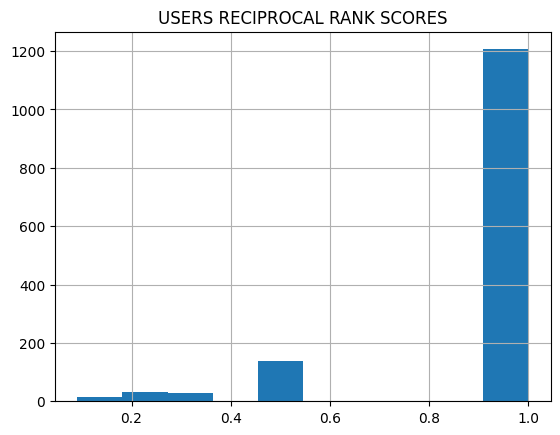

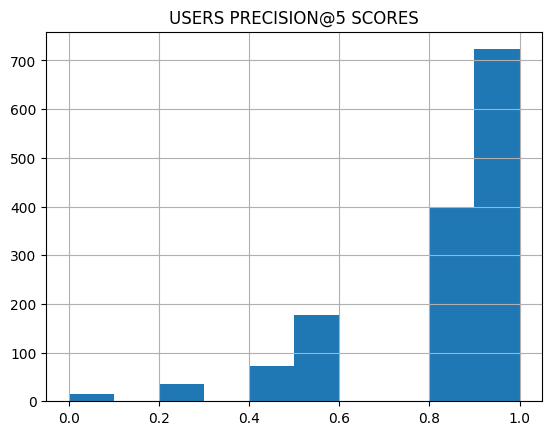

In [34]:
#####
K = 600
MIN_PROP = 0.25
MAX_PROP = 0.75
#####
print("----------")
print("Train data")
print("----------")

_ = lfm_model_evaluation(
    model, data_train_all,
    result_cols=result_cols,
    lfm_dataset=dataset,
    categorizer=categorizer,
    n=K, cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    target_col=target_column,
    score_col=score_column,
    train_user_weights=user_features,
    train_item_weights=item_features,
    min_prop=MIN_PROP, max_prop=MAX_PROP
)

### Not bad results, aren't they?)

### Save the model

In [35]:
with open(opt.path_to_models / opt.model.name, "wb") as fout:
    pickle.dump(model, fout)
with open(opt.path_to_models / opt.model.name, "rb") as fin:
    new_model = pickle.load(fin)

In [36]:
assert (model.get_item_representations()[1] == new_model.get_item_representations()[1]).all()